In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


### A Short (and incomplete) Tutorial of the Python NetCDF/NCL Tutorial
- After some soul searching and consternation, NOAA is adopting Python as its official scripting language.
- The beloved (or accursed) NCL will be left to history
- Sort of. At this time, the Python interface appears to principally be a wrapper around NCL, so that Ngl and Nio are libraries for writing NCL in Python (aka, Python_object.ncl_command() ), so everybody wins.
- Here, we show one or more quick, simple examples of reading and writing data to/from files, using the Python-NCL interface.

#### Some decent references:
- https://unidata.github.io/netcdf4-python/netCDF4/index.html



In [4]:
# NCL stuff:
#import Ngl
import Nio
#import pyncl
#
import pylab as plt
import numpy
import scipy
import scipy.constants
#
import os,sys
#import pathlib
import itertools

import getpass
import subprocess
import contextlib

def file_report(fin):
    # a simple script to print some information about the provided file (-handle)
    #
    dims = fin.dimensions.values()
    dimnames = fin.dimensions.keys()
    #
    varnames_all = fin.variables.keys()
    varnames = [s for s in varnames_all if not s in dimnames]
    #
    print('** dims: ', list(zip(dimnames, dims)))
    #
    print('** varnames_all: ', varnames_all)
    print('** varnames: ', varnames)
    #

    print('type(fin.dimensions): ', type(fin.dimensions) )
    #
    return None


### Mount network resource (sshfs), if we are working locally from a remote data set
- This will be provided for instructinal purposes, but we won't use it in these examples.
- This only if we want to pull down a (small) subset of data to our local machine
- use subprocess() to mount the remote FS
- Note we do * **not** * write our password in code, pull it from a (n unencrypted) data file, etc. In fact, in this script, we don't even write it to a variable
- Typically, if you are working on managed resources (aka, your NFS will probably be mounted)

### Create some data (that look sort of like atmospheric modeling)

In [5]:
output_file_path = 'pretend_data.nc'
my_lats = numpy.linspace(-90., 90, 10)
my_lons = numpy.linspace(-180., 180., 20)
my_elevs = numpy.arange(0, 10)*1000.
n_timesteps=100
my_time_steps = numpy.arange(0., n_timesteps)
#
os.system('rm {}'.format(output_file_path))
# do we need to delete the file?
with contextlib.closing(Nio.open_file(output_file_path, 'c')) as fout:
    #
    # defne dimensions (note we can use the scritped syntax below):
    fout.create_dimension('time', n_timesteps)
    fout.create_dimension('alt', len(my_elevs))
    fout.create_dimension('lat', len(my_lats))
    fout.create_dimension('lon', len(my_lons))
    #
    # assign values to dimension variables (using list scripted syntax)
    #fout.create_variable('time', 'f', ('time',) )
    # NOTE: variables types are 'f' for short(er) float; 'd' for a double, or long float.
#     fout.create_variable('lat', 'd', ('lat',))
#     fout.create_variable('lon', 'd', ('lon',))
#     fout.create_variable('alt', 'd', ('alt',))
#     fout.create_variable('time', 'd', ('time',))
#     #
#     # this breaks (something about types not matching)
#     #fout.variables['lat'].assign_value(my_lats[:])
#     # these work, but the object does not retain the values.
#     fout.variables['lat'][:] = my_lats
#     fout.variables['lon'][:] = my_lons
#     fout.variables['alt'][:] = my_elevs
#     fout.variables['time'][:] = my_time_steps
    
    for s,x in zip(['time', 'alt', 'lat', 'lon'], [my_time_steps, my_elevs, my_lats, my_lons]):
        #print('** {} / {}'.format(s, fout.dimensions[s]))
        #
        # note: 1) we provide the dimension of the variable as a tuple
        #  2) 'f' is a small float, 'd' is a big float ("double"); trying to assign 'd' values
        #.  into a type 'f' variable may throw an error (as it does in this case)
        #fout.create_variable(s, 'f', (s,) )
        fout.create_variable(s, 'd', (s,) )
        fout.variables[s][:]=x
        #print('** DEBUG: var[{}]: {}'.format(s, fout.variables[s]))
        print('** ** DEBUG: shape: ', numpy.shape(fout.variables[s]))
    #
    # Instantiate a data variable.
    # outf.create_variable('t','f',('time','lat','lon'))
    fout.create_variable('U','d',('time', 'alt', 'lat','lon'))
    setattr(fout.variables['U'], 'standard_name', 'pressure')
    setattr(fout.variables['U'], 'units', 'kPa')
    #
    print('** DEBUG: time: ', min(fout.variables['time']), max(fout.variables['time']))
    print('** DEBUG: lat: ', min(fout.variables['lat']), max(fout.variables['lat']))
    # variable assignment:
    # This syntax is required for scaler, non-indexed values (or so I have read):
    # fout.variables['u'].assign_value(udum)        # this works if dimensions align
    #. we can also use it for arrays, but only if we are assigning the whole value -- in other words, the 
    #. dimensinos must match. (this works if dim(udum)==dim(fout)). I assume the exception is if the output
    #. dimension is undefined, all other dimensions must match.
    #
    # For batched assignment, we can use:
    # fout.variables['u'][0:len(udum)] = udum      # use this for partial assignment (note, i think this does allow 
    #                                            # (aka, will expand) for overflow -- [k,j] > len(fout.variable) )
    #  if the dimenstions match, we can use this syntax without "slice" indices.
    #
    # and we might want to close the file here:
    print('file created: ')
    print(file_report(fout))
    #fout.close()
#

('** ** DEBUG: shape: ', (100,))
('** ** DEBUG: shape: ', (10,))
('** ** DEBUG: shape: ', (10,))
('** ** DEBUG: shape: ', (20,))
('** DEBUG: time: ', 0.0, 99.0)
('** DEBUG: lat: ', -90.0, 90.0)
file created: 
('** dims: ', [('lat', 10), ('alt', 10), ('lon', 20), ('time', 100)])
('** varnames_all: ', ['lat', 'U', 'alt', 'lon', 'time'])
('** varnames: ', ['U'])
('type(fin.dimensions): ', <type 'dict'>)
None


In [6]:
# Assign some values:
# NOTE: we could have done this during the 'create' phase, but we want to demonstrate 
#. opening and closing.
with contextlib.closing(Nio.open_file(output_file_path, 'r+')) as fout:
    #
    # if we just want to make our code work, we can do this:
    #fout.variables['U'] = numpy.random.random(size=list(fout.dimensions.values()))
    ##
    ## and even slightly differentiate the layers:
    ## add the index value to each altitude layer, so each layer is ~ 0+u, 1+u, 2+u, ...
    ##. (where u is a random number).
    #for k in range(0, fout.dimensions['alt']):
    #    fout.variables['U'][:,k,:,:] += k
    #
    # A more interesting example, fromm which we can make some pretty pictures:
    # compute some periodic constants:
    T_x = scipy.constants.pi/(max(fout.variables['lon']) - min(fout.variables['lon']))
    T_y = scipy.constants.pi/(max(fout.variables['lat']) - min(fout.variables['lat']))
    T_t = 2.*scipy.constants.pi/(max(fout.variables['time']) - min(fout.variables['time']))
    N_pi = numpy.arange(1, fout.dimensions['alt']+1,1)
    #
    #print('** DEBUG Ts: ', T_x, T_y, N_pi)
    #print('** DEBUG: T_t: ', min(fout.variables['time']) , max(fout.variables['time']))
    #print('** DEBUG: time2: ', min(fout.variables['time']), max(fout.variables['time']))
    #
    # Populate the array:
    # For 2D arrays, we can use numpy.meshgrid(Xs, Ys) to get a dense n_x x n_y array, but
    #. I don't think there is a 2D abstraction. We want to avoid a fully nested loop, unless
    #. memory is a restriction.
    #
    XX, YY = numpy.array(numpy.meshgrid( fout.variables['lon'], fout.variables['lat']) )
    XX *= T_x
    YY *= T_y
    #
    # there's a faster, numpy way to do this (rebroadcast as cartesian dimensions), but I'm just going to
    #. get it done. (can you meshgrid() nested objects?
    #
    #print('*** shape:', numpy.shape(fout.variables['U']))
    #
    # we can probably do this more efficiently using numpy.outer(X,Y); we can nest numpy.outer()
    #. calls, and then reshpae(), xx = numpy.outer(X, numpy.outer(Y,Z)).reshape(len(X), len(Y), len(Z)))
    #
    #
    for (k_t, phi),k_z in itertools.product(enumerate(fout.variables['time']*T_t), N_pi):
        #
        #print('** ** ', k_t, phi, k_z)
        #zs = numpy.cos(k_z*XX + phi)*numpy.sin(k_z*YY + phi)
        #print('** DEBUG: zs: ', numpy.shape(zs))
        fout.variables['U'][k_t, k_z, :,:] = numpy.cos(k_z*XX + phi)*numpy.sin(k_z*YY + phi)
        
        #if k_z>5: break
#


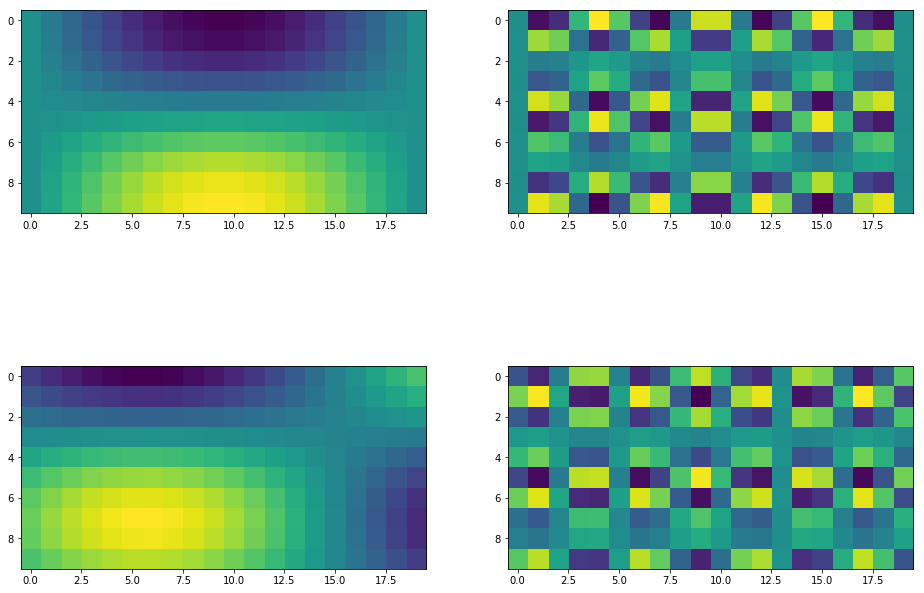

In [7]:
fg = plt.figure(figsize=(16,12))
axes = [plt.subplot(2,2,k+1) for k in range(4)]
#
with contextlib.closing(Nio.open_file(output_file_path, 'r')) as fin:
    #
    axes[0].imshow(fin.variables['U'][0,1,:,:])
    axes[1].imshow(fin.variables['U'][0,7,:,:])
    axes[2].imshow(fin.variables['U'][10,1,:,:])
    axes[3].imshow(fin.variables['U'][10,7,:,:])

In [8]:
X = numpy.outer(numpy.arange(5), numpy.arange(4))
print('** ', X)
XZ = numpy.outer(numpy.arange(3), X).reshape((3,5,4))
print('*** ', XZ)
print('shape: ', XZ.shape)
#
# XX,YY = numpy.array(numpy.meshgrid(numpy.arange(5), numpy.arange(10)))
# print('** ', XX.shape)
# print('** ', XX)
# #print('** ', YY)

# print('** ** \n', numpy.outer(numpy.ones(2),XX) )

# #with contextlib.closing(Nio.open_file(output_file_path, 'r+')) as fout:
# #    print('dims: ', fout.dimensions)



# #f = Nio.open_file(output_file_path, 'r')
# #print('dims: ', f.dimensions)

('** ', array([[ 0,  0,  0,  0],
       [ 0,  1,  2,  3],
       [ 0,  2,  4,  6],
       [ 0,  3,  6,  9],
       [ 0,  4,  8, 12]]))
('*** ', array([[[ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0]],

       [[ 0,  0,  0,  0],
        [ 0,  1,  2,  3],
        [ 0,  2,  4,  6],
        [ 0,  3,  6,  9],
        [ 0,  4,  8, 12]],

       [[ 0,  0,  0,  0],
        [ 0,  2,  4,  6],
        [ 0,  4,  8, 12],
        [ 0,  6, 12, 18],
        [ 0,  8, 16, 24]]]))
('shape: ', (3, 5, 4))
